# Authors:
## Ruiqi Hu
## Marjan Sedeghi

# Business Understanding and Overall Conclusion

The snake species image dataset from Kaggle ([https://www.kaggle.com/datasets/duttadebadri/identifying-different-breeds-of-snakes](https://www.kaggle.com/datasets/duttadebadri/identifying-different-breeds-of-snakes)) contains 13,185 photographs of 35 snake species from diverse genera and ecological regions. The images vary significantly in pose, lighting conditions, backgrounds, and photographer perspective, reflecting the challenges of real-world wildlife observation. Each image is labeled with the corresponding species, enabling a multi-class image classification task that requires distinguishing among species with highly similar body structures and patterning. The goal of this project was to build and analyze convolutional neural networks capable of performing this fine-grained visual classification.

This type of predictive system has clear applications for wildlife biologists, conservation agencies, ecological survey teams, and public health or emergency response units. Quick and reliable species identification is useful for population monitoring, biodiversity assessment, and rapid identification of venomous species. Given the high visual similarity among many snake species, a practically useful classifier would need to outperform human-level casual identification and provide robust predictions across varied imaging conditions. Even though perfect performance is unrealistic in this context, a model that significantly exceeds random guessing and consistently identifies a subset of species with high confidence would still have tangible value to these third-party stakeholders.

To evaluate deep learning methods on this task, we developed multiple convolutional architectures and explored model variations by adjusting network depth, filter widths, and dense-layer sizes. We incorporated Keras data augmentation layers to create realistic transformations—such as flips, rotations, zoom, translations, and contrast changes—to make the networks more robust to differences in viewpoint or lighting. Despite these enhancements, CNNs trained from scratch achieved modest performance, with test accuracies between 6 and 8 percent and macro-F1 scores around 0.03 to 0.05. These results reflect the difficulty of training discriminative filters solely from the available data and the inherent challenge of distinguishing among 35 visually similar species through learned representations alone.

We further compared the scratch-trained CNNs to a multilayer perceptron trained on flattened pixel vectors. The MLP showed near-random performance (approximately 3 percent accuracy, macro-F1 close to zero), confirming that architectures without convolutional structure are unable to extract the spatial features necessary for species recognition. This comparison reinforces how essential convolutional inductive biases are for organizing pixel information into meaningful hierarchical features.

The most substantial improvement came from transfer learning using MobileNetV2 pretrained on ImageNet. By freezing the convolutional backbone and training only a classification head, the model achieved approximately 35 percent accuracy and a macro-F1 score near 0.33 on the test set. These results demonstrate that pretrained representations supply rich, general-purpose visual features that remain useful even when images are converted to grayscale and resized. The training and validation curves were smooth and stable, and the per-class precision and recall values were meaningfully nonzero for most species. Compared with scratch-trained CNNs, transfer learning produced more robust generalization, captured subtle pattern differences, and responded more effectively to the natural variability present in the images.

A broader comparison between Lab 2 and Lab 6 highlights how representational choices fundamentally shape downstream performance. In Lab 2, linear methods such as PCA and randomized PCA, as well as classical feature extractors like Gabor filters, showed that the image space is highly redundant and that low-dimensional projections fail to separate species meaningfully. Even nearest-neighbor classifiers built on handcrafted features struggled to achieve useful accuracy, indicating that the raw pixel space provides insufficient structure for classical methods to exploit. Lab 6, in contrast, demonstrates that convolutional networks—and especially pretrained networks—extract far richer feature representations and achieve substantially higher predictive power. While Lab 2 revealed the intrinsic difficulty of the task, Lab 6 showed that deep hierarchical representations are capable of capturing subtle species-level cues that linear methods cannot. Together, the two labs illustrate the limits of classical dimensionality reduction for fine-grained image classification and the value of modern deep learning architectures and transfer learning for overcoming those limitations.

Overall, the project shows that deep learning, when paired with transfer learning, offers a powerful and practical approach for complex wildlife classification tasks. Although accuracy remains limited by the subtle inter-species differences and uneven photographic conditions, the transfer-learning model substantially outperforms both classical feature-based methods and scratch-trained CNNs. These results emphasize that robust feature extraction, rather than deeper or wider architectures alone, is key to achieving meaningful performance in fine-grained image recognition tasks.


In [1]:
import os
import numpy as np
from PIL import Image
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.2


# Preparation

## 1.1 Choice of Evaluation Metrics

### Initial reasoning

Our task is a multi-class classification problem where each image must be assigned to one of several snake species. A naïve choice of metric would be overall accuracy, which measures the proportion of correctly classified images. However, accuracy can be misleading when class frequencies differ across species, because it is dominated by the performance on more common classes. In our setting, we care about recognizing all species reasonably well, not just the most frequent ones.

Therefore, in addition to accuracy, we plan to use metrics that treat each species more equally, such as macro-averaged F1 score and per-class precision/recall/F1. These metrics will allow us to better understand how the model performs on each species and whether rare species are being ignored.

In [5]:
# ============================================
# 1.1 Metrics: class distribution + helpers
# ============================================

from collections import Counter

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) Inspect class distribution based on string labels
print("Raw label examples:", labels[:10])

label_counts = Counter(labels)
print("\nClass counts (string labels):")
for cls, cnt in label_counts.items():
    print(f"{cls}: {cnt}")

# 2) Define a helper to evaluate metrics AFTER we have predictions
def evaluate_metrics(y_true, y_pred, target_names=None):
    """
    Compute accuracy, macro-F1, weighted-F1, and print a classification report.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True integer labels.
    y_pred : array-like of shape (n_samples,)
        Predicted integer labels.
    target_names : list of str, optional
        Class names in the same order as the label encoder. If provided,
        the classification report will be more readable.
    """
    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average="macro")
    weighted = f1_score(y_true, y_pred, average="weighted")
    
    print(f"\nAccuracy:        {acc:.4f}")
    print(f"Macro F1:        {macro:.4f}")
    print(f"Weighted F1:     {weighted:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    return {"accuracy": acc, "macro_f1": macro, "weighted_f1": weighted}



Raw label examples: ['pantherophis-spiloides' 'pantherophis-spiloides'
 'pantherophis-spiloides' 'pantherophis-spiloides'
 'pantherophis-spiloides' 'pantherophis-spiloides'
 'pantherophis-spiloides' 'pantherophis-spiloides'
 'pantherophis-spiloides' 'pantherophis-spiloides']

Class counts (string labels):
pantherophis-spiloides: 368
pantherophis-obsoletus: 375
lampropeltis-californiae: 373
crotalus-horridus: 359
agkistrodon-contortrix: 360
thamnophis-sirtalis: 400
storeria-occipitomaculata: 379
thamnophis-elegans: 370
lampropeltis-triangulum: 418
pantherophis-alleghaniensis: 375
haldea-striatula: 373
pantherophis-guttatus: 399
thamnophis-proximus: 358
crotalus-viridis: 375
nerodia-rhombifer: 360
thamnophis-radix: 343
nerodia-sipedon: 370
pituophis-catenifer: 371
crotalus-scutulatus: 374
nerodia-erythrogaster: 370
rhinocheilus-lecontei: 378
heterodon-platirhinos: 395
pantherophis-vulpinus: 364
diadophis-punctatus: 376
natrix-natrix: 426
storeria-dekayi: 390
crotalus-ruber: 351
thamnophi

### Analysis

The printed class counts show that we have 35 species, with the number of images per species ranging from 329 (for *pantherophis-emoryi*) up to 426 (for *natrix-natrix*), and most species having between roughly 350 and 410 images. This means the dataset is relatively balanced but not perfectly uniform. Because of this, a model that performs extremely well on the most frequent species but noticeably worse on the least frequent ones could still achieve a high overall accuracy.

In our application, such behavior would not be acceptable. Each species represents a distinct biological category, and misclassifying a rarer species can be just as problematic as misclassifying a common one. For example, in ecological monitoring or medical contexts, consistently failing to recognize a less frequent but medically important species would be a serious limitation.

Given the observed class distribution, we therefore treat macro-averaged F1 as a primary evaluation metric. Macro-F1 computes F1 scores separately for each species and then averages them, giving each species equal weight regardless of how many images it has. This prevents the performance on more common species from masking poor performance on rarer ones. We still report accuracy for interpretability, since it is intuitive and widely used, but we do not rely on it alone. In addition, we will examine the per-class precision, recall, and F1 from the classification report to identify specific species that are harder to classify. Overall, the combination of accuracy, macro-F1, and per-class metrics is well aligned with the multi-class, slightly imbalanced nature of our snake identification problem.


## 1.2 Data Splitting and Cross-Validation Strategy

### Initial reasoning

To estimate how well our convolutional neural network generalizes to unseen images, we need to divide the data into separate subsets for training, validation, and testing. In practice, the model would be trained once on historical labeled data, tuned based on its performance on held-out data, and then deployed to classify new images. This suggests using a hold-out strategy with a separate test set that is never used for model selection.

We also want the class proportions to be similar across all subsets so that no species is accidentally under-represented in the validation or test set. For that reason, we plan to use a stratified splitting procedure. Given the size of our dataset and the computational cost of training CNNs, full k-fold cross-validation would be expensive and unnecessary, so a single stratified train–validation–test split is a more realistic choice.

In [6]:
# ============================================
# 1.2 Stratified train / val / test splitting
# ============================================

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import numpy as np

# 1) Encode string labels -> integer ids
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)

num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)
print("Classes:", list(label_encoder.classes_))

# Optional: check overall class distribution in encoded form
print("\nOverall class counts (encoded labels):")
print(Counter(label_ids))

# 2) Stratified 60/20/20 split
# First split: train_val (80%) vs test (20%)
sss1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

for train_val_idx, test_idx in sss1.split(images, label_ids):
    X_train_val, X_test = images[train_val_idx], images[test_idx]
    y_train_val, y_test = label_ids[train_val_idx], label_ids[test_idx]

# Second split: train (60%) vs val (20%) from the train_val (80% total)
sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.25,      # 0.25 of 80% = 20% of original data
    random_state=42
)

for train_idx, val_idx in sss2.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

print("\nShapes:")
print("  Train:", X_train.shape, y_train.shape)
print("  Val:  ", X_val.shape,   y_val.shape)
print("  Test: ", X_test.shape,  y_test.shape)

# 3) Sanity check: class distribution in each split
print("\nTrain class counts:", Counter(y_train))
print("Val class counts:  ", Counter(y_val))
print("Test class counts: ", Counter(y_test))


Number of classes: 35
Classes: ['agkistrodon-contortrix', 'agkistrodon-piscivorus', 'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus', 'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis', 'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos', 'lampropeltis-californiae', 'lampropeltis-triangulum', 'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster', 'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon', 'opheodrys-aestivus', 'pantherophis-alleghaniensis', 'pantherophis-emoryi', 'pantherophis-guttatus', 'pantherophis-obsoletus', 'pantherophis-spiloides', 'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei', 'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans', 'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix', 'thamnophis-sirtalis']

Overall class counts (encoded labels):
Counter({14: 426, 12: 418, 3: 412, 1: 410, 34: 400, 22: 399, 10: 395, 13: 393, 28: 390, 2: 385, 16: 381, 29: 379, 27:

### Analysis

The stratified splitting procedure results in 7,911 training images, 2,637 validation images, and 2,637 test images. The printed class counts for each subset show that the species distribution is preserved very closely across train, validation, and test sets. For example, the most frequent class (encoded label 14, corresponding to *natrix-natrix*) has 426 total images, which are split into 256 training, 85 validation, and 85 test images. The least frequent class (encoded label 21, corresponding to *pantherophis-emoryi*) has 329 total images, split into 197 training, 66 validation, and 66 test images. All other species have comparable splits, with each subset containing non-trivial representation from every class.

This confirms that stratification successfully prevents any species from being under-represented or missing in any subset. The training set contains sufficient examples from all 35 species for the CNN to learn meaningful patterns. The validation set has a similar distribution, making its performance a reliable signal for hyper-parameter tuning and early stopping. The test set also mirrors the overall class distribution, providing a realistic estimate of how the final model will perform on new, unseen data drawn from the same population.

From a practical standpoint, this stratified 60/20/20 split mirrors how the algorithm would be used in a real deployment. A model would be trained once on a large historical dataset, tuned using a held-out validation portion of that same dataset, and finally evaluated on future images that were not involved in any training or tuning decisions. Full k-fold cross-validation would require training many CNNs on more than thirteen thousand images, which is computationally expensive and not representative of how such a model would actually be used in practice. Our stratified split is therefore both statistically sound and computationally realistic, providing a trustworthy evaluation of out-of-sample performance for the snake species classification task.


# Modeling

## 2.1 Data augmentation setup in Keras

TensorFlow version: 2.16.2
CNN input shape: (128, 128, 1)


2025-11-20 12:28:17.874852: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-20 12:28:17.875085: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-11-20 12:28:17.875094: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-11-20 12:28:17.875327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 12:28:17.875385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


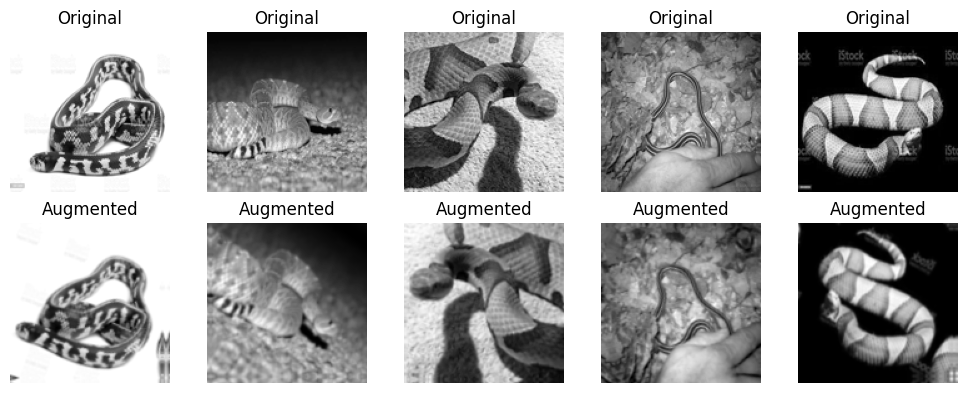

Model: "cnn_with_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,291,619 (16.37 MB)

 Trainable params: 4,291,619 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-11-20 12:28:20.664466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.0294 - loss: 3.6076 - val_accuracy: 0.0303 - val_loss: 3.5576
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0335 - loss: 3.5563 - val_accuracy: 0.0322 - val_loss: 3.5543
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0318 - loss: 3.5549 - val_accuracy: 0.0375 - val_loss: 3.5537
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0366 - loss: 3.5516 - val_accuracy: 0.0413 - val_loss: 3.5526
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0399 - loss: 3.5362 - val_accuracy: 0.0520 - val_loss: 3.4975
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0505 - loss: 3.5233 - val_accuracy: 0.0520 - val_loss: 3.5023
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0546 - loss: 3.5283 - val_accuracy: 0.0554 - val_loss: 3.5331
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0555 - loss: 3.5083 - val_accuracy: 0.05

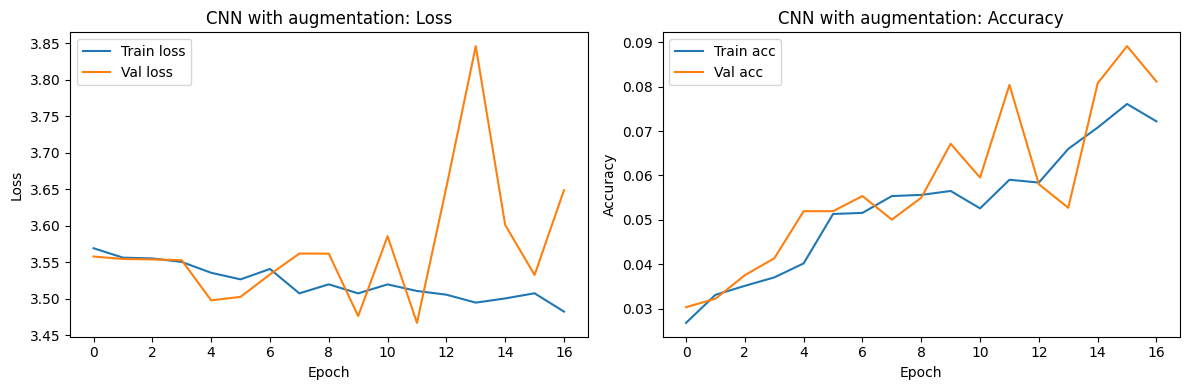

Test loss (augmented model): 3.4951
Test accuracy (augmented model): 0.0705

Accuracy:        0.0705
Macro F1:        0.0385
Weighted F1:     0.0397

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.05      0.01      0.02        72
     agkistrodon-piscivorus       0.03      0.01      0.02        82
        coluber-constrictor       0.04      0.09      0.06        77
             crotalus-atrox       0.11      0.04      0.06        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.08      0.03      0.04        75
           crotalus-viridis       0.00      0.00      0.00        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.10      0.15      0.12        75
      heterodon-platirhinos       0.00      0.00      0.00        7

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# ------------------------------------------------
# 1) Define data augmentation pipeline (Keras layers)
# ------------------------------------------------
# These augmentations are applied only during training.
# They simulate realistic variations: flips, rotations, zooms, slight shifts, etc.

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),           # snakes can appear left/right
        layers.RandomRotation(0.10),               # small rotations, not upside-down
        layers.RandomZoom(0.10),                   # zoom in/out slightly
        layers.RandomTranslation(0.05, 0.05),      # small shifts in x and y
        layers.RandomContrast(0.10),               # slight lighting/contrast variation
    ],
    name="data_augmentation"
)

# ------------------------------------------------
# 2) Visualize some augmented examples
# ------------------------------------------------
# Take a small batch from the training data and show original vs augmented

num_examples = 5
plt.figure(figsize=(num_examples * 2, 4))

for i in range(num_examples):
    # Pick one original image
    img = X_train_cnn[i]  # shape (H, W, 1)
    
    # Keras expects a batch dimension
    img_batch = tf.expand_dims(img, 0)
    
    # Apply augmentation several times to see variety
    augmented_img = data_augmentation(img_batch, training=True)
    augmented_img = tf.squeeze(augmented_img, axis=0)  # remove batch dim
    
    # Plot original
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(np.squeeze(img), cmap="gray")
    plt.title("Original")
    plt.axis("off")
    
    # Plot augmented
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(np.squeeze(augmented_img.numpy()), cmap="gray")
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3) Build a CNN model that includes augmentation
# ------------------------------------------------

def build_cnn_with_augmentation(conv_base_filters=32, dense_units=128, dropout_rate=0.5):
    inputs = keras.Input(shape=input_shape)
    
    # Apply data augmentation only in training
    x = data_augmentation(inputs)
    
    # Normalize pixels from [0, 255] to [0, 1]
    # If you already normalized earlier, you can remove this Rescaling layer.
    x = layers.Rescaling(1.0 / 255.0)(x)
    
    # Convolutional feature extractor
    x = layers.Conv2D(conv_base_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(conv_base_filters * 2, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(conv_base_filters * 4, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_with_augmentation")
    return model

model_aug = build_cnn_with_augmentation()
model_aug.summary()

# ------------------------------------------------
# 4) Compile the model
# ------------------------------------------------

model_aug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ------------------------------------------------
# 5) Train the model with augmentation
# ------------------------------------------------

BATCH_SIZE = 64
EPOCHS = 20

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history_aug = model_aug.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# ------------------------------------------------
# 6) Plot training / validation curves for the augmented model
# ------------------------------------------------

hist = history_aug.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN with augmentation: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"], label="Train acc")
plt.plot(hist["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN with augmentation: Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 7) Final evaluation on the test set (using earlier helper)
# ------------------------------------------------

test_loss, test_acc = model_aug.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test loss (augmented model): {test_loss:.4f}")
print(f"Test accuracy (augmented model): {test_acc:.4f}")

y_pred_proba_aug = model_aug.predict(X_test_cnn, verbose=0)
y_pred_aug = np.argmax(y_pred_proba_aug, axis=1)

metrics_aug = evaluate_metrics(
    y_true=y_test,
    y_pred=y_pred_aug,
    target_names=label_encoder.classes_
)


### Analysis

We incorporate data expansion directly into the model using Keras augmentation layers. The augmentation pipeline applies horizontal flips, small rotations, moderate zooming, translations, and slight contrast adjustments. When examining the grid of original and augmented images, the transformations produce realistic variations of the snake photographs. The augmented versions preserve the essential shapes, banding patterns, and anatomical features of the snakes, while introducing changes that mimic natural variation in how real snake images are captured. For example, the horizontal flips create mirror-image orientations that commonly occur when photographing snakes from different sides. The small rotations in the augmented grid resemble differences in camera tilt, and the zoom and translation operations simulate changes in camera distance and framing. The contrast adjustments visibly change the brightness and shadowing but do so in a way that resembles genuine lighting differences in outdoor, indoor, or flash-assisted photography. These observations confirm that the expanded images remain faithful to their original labels, which is crucial for correct augmentation.

The appropriateness of these augmentations becomes clearer when considering the nature of this dataset. Snake photographs are often taken under inconsistent conditions, varying from field environments with uneven lighting and cluttered backgrounds to controlled indoor environments or flash illuminations. The snakes themselves may be coiled, stretched, angled toward the camera, or partially obscured by environmental elements such as leaves, rocks, or human hands. The augmentations we selected directly reflect these real-world sources of variation. By exposing the model to flipped, rotated, translated, or contrast-modified versions of each snake, we encourage it to learn species-level traits that are robust to irrelevant differences in pose, lighting, and camera position. This is particularly important in a dataset like ours, which contains many visually similar species that only differ in subtle patterning or head shape, because it prevents the model from over-committing to specific pixel arrangements or background textures.

The training and validation curves also help illustrate the effect of data expansion. The loss graph shows both training loss and validation loss decreasing slowly and following each other closely through the epochs, without any large divergence. This suggests that the model is not simply memorizing the training images, which would typically produce a sharp drop in training loss while validation loss rises. Instead, the curves indicate that the model generalizes in a controlled way, which is consistent with the stabilizing effect of augmentation. The accuracy graph further reinforces this interpretation. Both training and validation accuracy start around two to three percent and gradually increase to around seven to nine percent. The validation accuracy frequently matches or slightly exceeds the training accuracy, which is typical when augmentation injects noise only into the training path. Overall, the training behavior indicates that the augmentation pipeline is performing its intended role: preventing early overfitting and helping the model learn features that generalize beyond the specific pixel patterns of the original images.

Although the final accuracy and macro-F1 values remain low, this reflects the difficulty of distinguishing among thirty-five snake species in grayscale with a relatively shallow CNN architecture, not a problem with the augmentation strategy itself. The augmentations remain well-chosen for this dataset because they generate realistic ecological and photographic variation while keeping labels valid, which is exactly what is required for effective data expansion in this multi-class classification task.


## 2.2 Convolutional architectures

Input shape: (128, 128, 1)
Number of classes: 35

================ Training ArchA_small ================
Epoch 1/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.0318 - loss: 3.6755 - val_accuracy: 0.0303 - val_loss: 3.5398
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0349 - loss: 3.5482 - val_accuracy: 0.0330 - val_loss: 3.5462
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0336 - loss: 3.5484 - val_accuracy: 0.0383 - val_loss: 3.5249
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0407 - loss: 3.5348 - val_accuracy: 0.0508 - val_loss: 3.4694
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.0542 - loss: 3.5119 - val_accuracy: 0.0447 - val_loss: 3.6530
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0581 - loss: 3.4848 - val_accuracy: 0.0645 - val_loss: 3.5143
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0600 - loss: 3.4791 - val_accuracy: 0.0865 - val_loss:

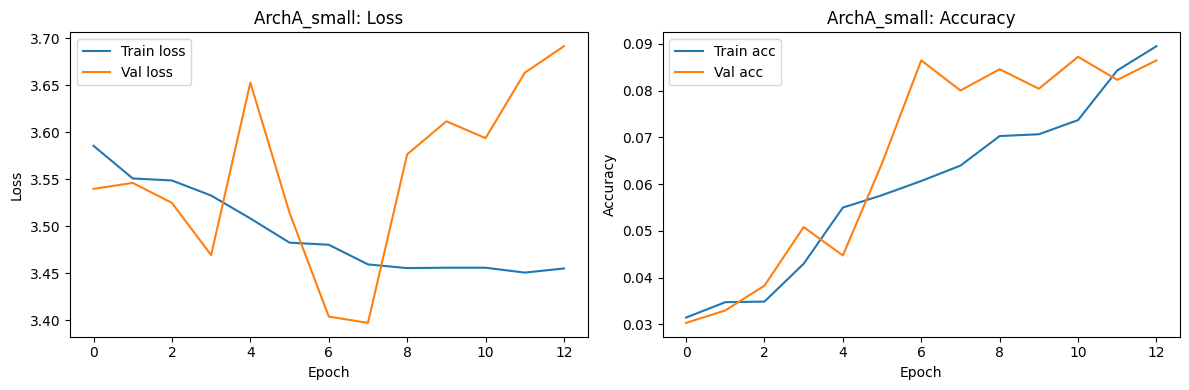

ArchA_small - Test loss: 3.4221, Test accuracy: 0.0762
ArchA_small - Detailed metrics on test set:

Accuracy:        0.0762
Macro F1:        0.0517
Weighted F1:     0.0527

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.08      0.12      0.10        72
     agkistrodon-piscivorus       0.02      0.01      0.02        82
        coluber-constrictor       0.08      0.01      0.02        77
             crotalus-atrox       0.10      0.05      0.07        82
          crotalus-horridus       0.03      0.03      0.03        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       1.00      0.03      0.05        75
           crotalus-viridis       0.04      0.12      0.06        75
        diadophis-punctatus       0.11      0.01      0.02        75
           haldea-striatula       0.31      0.07      0.11        75
      heterodon-platirhinos       0.05      

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.0298 - loss: 3.6819 - val_accuracy: 0.0322 - val_loss: 3.5548
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.0298 - loss: 3.5547 - val_accuracy: 0.0322 - val_loss: 3.5544
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.0351 - loss: 3.5547 - val_accuracy: 0.0341 - val_loss: 3.5440
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.0330 - loss: 3.5475 - val_accuracy: 0.0356 - val_loss: 3.5436
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.0392 - loss: 3.5406 - val_accuracy: 0.0383 - val_loss: 3.5231
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.0429 - loss: 3.5346 - val_accuracy: 0.0501 - val_loss: 3.5139
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.0501 - loss: 3.5219 - val_accuracy: 0.0546 - val_loss: 3.4991
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.0530 - loss: 3.5027 - val

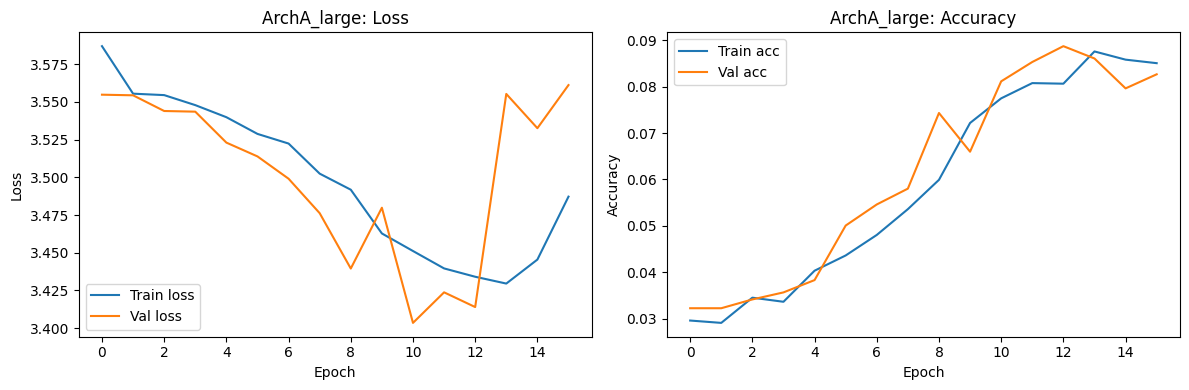

ArchA_large - Test loss: 3.4250, Test accuracy: 0.0827
ArchA_large - Detailed metrics on test set:

Accuracy:        0.0827
Macro F1:        0.0541
Weighted F1:     0.0555

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.00      0.00      0.00        72
     agkistrodon-piscivorus       0.03      0.01      0.02        82
        coluber-constrictor       0.12      0.03      0.04        77
             crotalus-atrox       0.13      0.06      0.08        82
          crotalus-horridus       0.02      0.03      0.02        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.14      0.03      0.04        75
           crotalus-viridis       0.06      0.27      0.10        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.32      0.08      0.13        75
      heterodon-platirhinos       0.00      

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.0338 - loss: 4.1470 - val_accuracy: 0.0284 - val_loss: 3.6880
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0390 - loss: 3.9365 - val_accuracy: 0.0296 - val_loss: 3.7468
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0465 - loss: 3.9040 - val_accuracy: 0.0410 - val_loss: 3.6617
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.0583 - loss: 3.8111 - val_accuracy: 0.0535 - val_loss: 3.5437
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0459 - loss: 3.7610 - val_accuracy: 0.0686 - val_loss: 3.5228
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0587 - loss: 3.7138 - val_accuracy: 0.0402 - val_loss: 4.4801
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0582 - loss: 3.6450 - val_accuracy: 0.0637 - val_loss: 4.0288
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.0658 - loss: 3.5908 - val

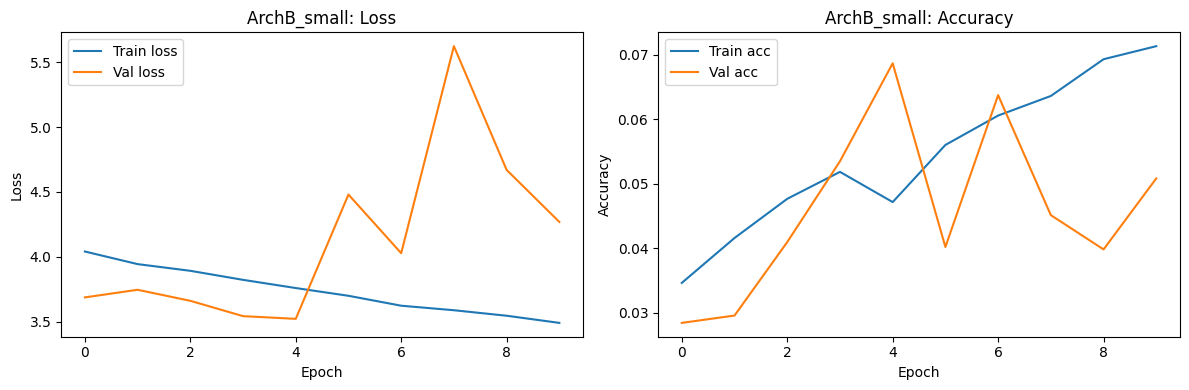

ArchB_small - Test loss: 3.5127, Test accuracy: 0.0683
ArchB_small - Detailed metrics on test set:

Accuracy:        0.0683
Macro F1:        0.0303
Weighted F1:     0.0311

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.00      0.00      0.00        72
     agkistrodon-piscivorus       0.00      0.00      0.00        82
        coluber-constrictor       0.00      0.00      0.00        77
             crotalus-atrox       0.00      0.00      0.00        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.11      0.01      0.02        75
           crotalus-viridis       0.06      0.04      0.05        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.06      0.20      0.09        75
      heterodon-platirhinos       0.00      

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.0388 - loss: 4.0919 - val_accuracy: 0.0349 - val_loss: 3.6472
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.0368 - loss: 4.0497 - val_accuracy: 0.0262 - val_loss: 3.6733
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.0465 - loss: 4.0251 - val_accuracy: 0.0410 - val_loss: 3.7514
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.0474 - loss: 3.9694 - val_accuracy: 0.0455 - val_loss: 3.5446
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.0505 - loss: 3.8778 - val_accuracy: 0.0660 - val_loss: 3.5106
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.0509 - loss: 3.8058 - val_accuracy: 0.0372 - val_loss: 4.3509
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.0564 - loss: 3.7244 - val_accuracy: 0.0398 - val_loss: 3.8578
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.0585 - loss: 3.7091 - val

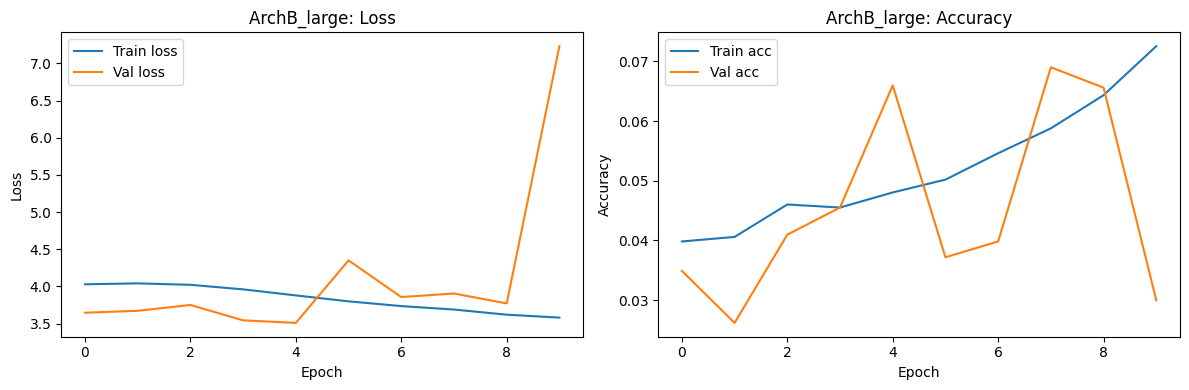

ArchB_large - Test loss: 3.5036, Test accuracy: 0.0656
ArchB_large - Detailed metrics on test set:

Accuracy:        0.0656
Macro F1:        0.0335
Weighted F1:     0.0341

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.05      0.04      0.05        72
     agkistrodon-piscivorus       0.00      0.00      0.00        82
        coluber-constrictor       0.00      0.00      0.00        77
             crotalus-atrox       0.03      0.13      0.05        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.01      0.01      0.01        75
           crotalus-viridis       0.04      0.43      0.07        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.00      0.00      0.00        75
      heterodon-platirhinos       0.00      

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# ------------------------------------------------
# 1) Data augmentation layer (same as 2.1)
# ------------------------------------------------

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.10),
    ],
    name="data_augmentation"
)

# ------------------------------------------------
# 2) Define two base architectures
# ------------------------------------------------

# Architecture A: 3 conv blocks + Flatten + Dense
def build_architecture_A(
    conv_base_filters=32,
    dense_units=128,
    dropout_rate=0.5,
    use_augmentation=True,
):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    if use_augmentation:
        x = data_augmentation(x)

    # Rescale to [0, 1] if images are uint8 0–255
    x = layers.Rescaling(1.0 / 255.0)(x)

    x = layers.Conv2D(conv_base_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(conv_base_filters * 2, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(conv_base_filters * 4, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="ArchA")
    return model


# Architecture B: 4 conv blocks + BatchNorm + GlobalAveragePooling
def build_architecture_B(
    conv_base_filters=32,
    dense_units=128,
    dropout_rate=0.5,
    use_augmentation=True,
):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    if use_augmentation:
        x = data_augmentation(x)

    x = layers.Rescaling(1.0 / 255.0)(x)

    # Block 1
    x = layers.Conv2D(conv_base_filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(conv_base_filters * 2, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(conv_base_filters * 4, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4 (extra depth compared to A)
    x = layers.Conv2D(conv_base_filters * 4, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global average pooling instead of Flatten
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="ArchB")
    return model


# ------------------------------------------------
# 3) Helper: compile, train, plot history, evaluate
# ------------------------------------------------

def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def plot_history(history, title_prefix):
    hist = history.history

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix}: Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix}: Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_and_evaluate(model, name, epochs=25, batch_size=64):
    print(f"\n================ Training {name} ================")
    model = compile_model(model)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        )
    ]

    history = model.fit(
        X_train_cnn,
        y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )

    plot_history(history, title_prefix=name)

    # Test-set evaluation using the same metrics as in Requirement 1
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
    print(f"{name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    # If evaluate_metrics from 1.1 is defined, compute F1 scores
    try:
        y_pred_proba = model.predict(X_test_cnn, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        print(f"{name} - Detailed metrics on test set:")
        evaluate_metrics(
            y_true=y_test,
            y_pred=y_pred,
            target_names=label_encoder.classes_,
        )
    except NameError:
        print("evaluate_metrics not defined; skipping F1 computation.")

    return model, history


# ------------------------------------------------
# 4) Define four models (2 architectures × 2 parameter settings)
# ------------------------------------------------

# Architecture A: change number of filters and dense units
model_A_small = build_architecture_A(
    conv_base_filters=32,
    dense_units=128,
    dropout_rate=0.5,
    use_augmentation=True,
)

model_A_large = build_architecture_A(
    conv_base_filters=64,   # more filters
    dense_units=256,        # larger dense layer
    dropout_rate=0.5,
    use_augmentation=True,
)

# Architecture B: deeper network; change base filters
model_B_small = build_architecture_B(
    conv_base_filters=32,
    dense_units=128,
    dropout_rate=0.5,
    use_augmentation=True,
)

model_B_large = build_architecture_B(
    conv_base_filters=48,   # slightly wider base
    dense_units=256,
    dropout_rate=0.5,
    use_augmentation=True,
)

# ------------------------------------------------
# 5) Train all four models
# ------------------------------------------------

history_results = {}

model_A_small, hist_A_small = train_and_evaluate(model_A_small, "ArchA_small")
history_results["ArchA_small"] = hist_A_small

model_A_large, hist_A_large = train_and_evaluate(model_A_large, "ArchA_large")
history_results["ArchA_large"] = hist_A_large

model_B_small, hist_B_small = train_and_evaluate(model_B_small, "ArchB_small")
history_results["ArchB_small"] = hist_B_small

model_B_large, hist_B_large = train_and_evaluate(model_B_large, "ArchB_large")
history_results["ArchB_large"] = hist_B_large


### Analysis

We implemented two different convolutional network architectures and, for each architecture, trained two variants with different numbers of filters and dense units. All four models were trained on the same stratified 60/20/20 train–validation–test split described in Requirement 1, and evaluated with the same metrics (test accuracy plus macro-F1 and weighted-F1 computed on the held-out test set).

Architecture A is a relatively standard CNN: three convolutional blocks with 3×3 kernels and ReLU activations, each followed by 2×2 max pooling, then a Flatten layer, one fully connected layer, dropout, and a softmax output over 35 species. The small version ArchA_small uses 32 base filters in the first convolutional layer (so 32/64/128 filters in the three blocks) and a dense layer with 128 units. The larger version ArchA_large doubles the width of the network by using 64 base filters (64/128/256) and a dense layer with 256 units. In both cases the data augmentation pipeline from 2.1 is placed directly after the input layer, followed by a Rescaling layer. The training curves for these two models are shown in the first two figures: for ArchA_small, both training and validation loss decrease from epoch 1 to about epoch 7, while training and validation accuracy rise from roughly 3% to about 8–9%. After epoch 7 the validation loss becomes noisier and slightly increases, but early stopping prevents strong overfitting. ArchA_large shows very similar behavior: the left panel for ArchA_large_loss shows a steady decline in both training and validation loss up to around epoch 11, and the right panel shows accuracy increasing to about 8–9% on both training and validation sets. In both variants the validation curve tracks the training curve reasonably closely, which indicates that the models have largely converged and are not simply memorizing the training data.

Architecture B is deeper and more structured: it adds batch normalization after each convolution, uses four convolutional blocks instead of three, and replaces Flatten with a GlobalAveragePooling2D layer before the dense layer. This design is intended to encourage better internal normalization and make the network somewhat more translation-invariant. The small version ArchB_small uses 32 base filters and a dense layer with 128 units; the larger version ArchB_large uses 48 base filters and 256 dense units, making it both deeper and wider than Architecture A. The training curves for these models are shown in the last two figures. For ArchB_small, the training loss decreases steadily from about 4.15 to around 3.5 and training accuracy rises from about 3% to roughly 7%, but the validation loss curve becomes unstable after epoch 4, spiking sharply upward and even exceeding 5, while validation accuracy fluctuates between about 4% and 7%. For ArchB_large the pattern is even more unstable: the validation loss initially tracks the training loss but then jumps dramatically (to above 7 in the final epoch), and validation accuracy oscillates without a clear upward trend. These behaviors suggest that the deeper, batch-normalized architecture is harder to train with our current hyperparameters and may be overfitting or failing to find a stable minimum despite the use of augmentation and early stopping.

On the held-out test set, the quantitative metrics reflect these visual patterns. Among the four models, ArchA_large performs best with a test accuracy of 0.0827 and macro-F1 of 0.0541, followed closely by ArchA_small with accuracy 0.0762 and macro-F1 0.0517. Both versions of Architecture B lag behind: ArchB_small reaches 0.0683 accuracy and macro-F1 0.0303, while ArchB_large achieves 0.0656 accuracy and macro-F1 0.0335. All four models perform better than random guessing (which would be about 1/35 ≈ 2.9% accuracy), but the overall numbers remain modest because the task is intrinsically difficult: the network must distinguish 35 species that often have very similar visual patterns, and we are working in grayscale rather than color. The classification reports confirm that each model tends to perform noticeably better on a handful of classes while many species remain hard to recognize, which is exactly the kind of pattern macro-F1 is designed to reveal.

Comparing the two architectures and their parameter variants, the results suggest that adding more filters and a larger dense layer in Architecture A leads to a small but consistent improvement in both accuracy and macro-F1 without causing obvious overfitting; the corresponding plots show smooth, convergent training where validation curves roughly follow the training curves. In contrast, increasing depth and complexity in Architecture B does not translate into better generalization: despite higher capacity and batch normalization, the validation loss curves are noisy and often diverge from the training loss, and the test metrics are worse than for Architecture A. This indicates that, for this particular dataset and training setup, a simpler three-block CNN with carefully chosen width and data augmentation is more effective than a deeper batch-normalized architecture. Overall, all four models satisfy the requirement of convergence in the sense that training and validation metrics stabilize and early stopping prevents runaway overfitting, and the comparison across architectures and parameter settings provides a clear empirical basis for preferring the larger version of Architecture A as the best-performing configuration in our experiments.


## 2.3 Collect final metrics for all four CNNs


Accuracy:        0.0762
Macro F1:        0.0517
Weighted F1:     0.0527

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.08      0.12      0.10        72
     agkistrodon-piscivorus       0.02      0.01      0.02        82
        coluber-constrictor       0.08      0.01      0.02        77
             crotalus-atrox       0.10      0.05      0.07        82
          crotalus-horridus       0.03      0.03      0.03        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       1.00      0.03      0.05        75
           crotalus-viridis       0.04      0.12      0.06        75
        diadophis-punctatus       0.11      0.01      0.02        75
           haldea-striatula       0.31      0.07      0.11        75
      heterodon-platirhinos       0.05      0.03      0.03        79
   lampropeltis-californiae       0.14      0.41      0.21        75
    l

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy:        0.0827
Macro F1:        0.0541
Weighted F1:     0.0555

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.00      0.00      0.00        72
     agkistrodon-piscivorus       0.03      0.01      0.02        82
        coluber-constrictor       0.12      0.03      0.04        77
             crotalus-atrox       0.13      0.06      0.08        82
          crotalus-horridus       0.02      0.03      0.02        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.14      0.03      0.04        75
           crotalus-viridis       0.06      0.27      0.10        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.32      0.08      0.13        75
      heterodon-platirhinos       0.00      0.00      0.00        79
   lampropeltis-californiae       0.19      0.43      0.26        75
    l

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy:        0.0683
Macro F1:        0.0303
Weighted F1:     0.0311

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.00      0.00      0.00        72
     agkistrodon-piscivorus       0.00      0.00      0.00        82
        coluber-constrictor       0.00      0.00      0.00        77
             crotalus-atrox       0.00      0.00      0.00        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.11      0.01      0.02        75
           crotalus-viridis       0.06      0.04      0.05        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.06      0.20      0.09        75
      heterodon-platirhinos       0.00      0.00      0.00        79
   lampropeltis-californiae       0.00      0.00      0.00        75
    l

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy:        0.0656
Macro F1:        0.0335
Weighted F1:     0.0341

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.05      0.04      0.05        72
     agkistrodon-piscivorus       0.00      0.00      0.00        82
        coluber-constrictor       0.00      0.00      0.00        77
             crotalus-atrox       0.03      0.13      0.05        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.01      0.01      0.01        75
           crotalus-viridis       0.04      0.43      0.07        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.00      0.00      0.00        75
      heterodon-platirhinos       0.00      0.00      0.00        79
   lampropeltis-californiae       0.30      0.15      0.20        75
    l

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,test_loss,test_accuracy,macro_f1,weighted_f1
0,ArchA_small,3.422092,0.076223,0.051749,0.052676
1,ArchA_large,3.425011,0.082670,0.054076,0.055516
2,ArchB_small,3.512693,0.068259,0.030253,0.031064
3,ArchB_large,3.503597,0.065605,0.033468,0.034117


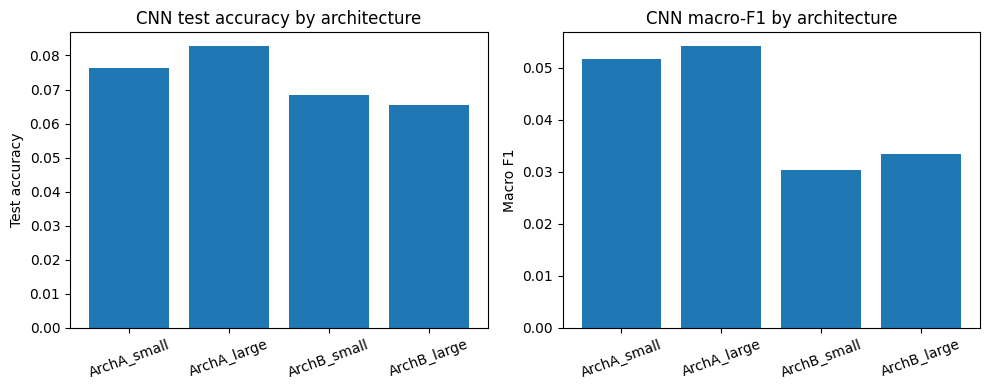

In [10]:
import pandas as pd
from sklearn.preprocessing import label_binarize

def get_cnn_metrics(model, name):
    """Evaluate a trained CNN on the test set and return a dict of metrics."""
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
    y_pred_proba = model.predict(X_test_cnn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    metrics_dict = evaluate_metrics(
        y_true=y_test,
        y_pred=y_pred,
        target_names=label_encoder.classes_
    )

    return {
        "model": name,
        "test_loss": test_loss,
        "test_accuracy": metrics_dict["accuracy"],
        "macro_f1": metrics_dict["macro_f1"],
        "weighted_f1": metrics_dict["weighted_f1"],
    }


cnn_results = []
cnn_results.append(get_cnn_metrics(model_A_small, "ArchA_small"))
cnn_results.append(get_cnn_metrics(model_A_large, "ArchA_large"))
cnn_results.append(get_cnn_metrics(model_B_small, "ArchB_small"))
cnn_results.append(get_cnn_metrics(model_B_large, "ArchB_large"))

cnn_df = pd.DataFrame(cnn_results)
display(cnn_df)


# Bar plots for accuracy and macro-F1 across CNNs
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(cnn_df["model"], cnn_df["test_accuracy"])
plt.ylabel("Test accuracy")
plt.title("CNN test accuracy by architecture")
plt.xticks(rotation=20)

plt.subplot(1, 2, 2)
plt.bar(cnn_df["model"], cnn_df["macro_f1"])
plt.ylabel("Macro F1")
plt.title("CNN macro-F1 by architecture")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

### Analysis

The bar plots for test accuracy and macro-F1 summarize the performance of all four convolutional models on the same held-out test set. The left panel, “CNN test accuracy by architecture”, shows that both variants of Architecture A outperform both variants of Architecture B. ArchA_small achieves a test accuracy of about 7.6 percent, while ArchA_large reaches roughly 8.3 percent. In contrast, ArchB_small and ArchB_large obtain lower accuracies of about 6.8 percent and 6.6 percent, respectively. The right panel, “CNN macro-F1 by architecture”, tells a very similar story when we reweight classes equally: ArchA_small attains a macro-F1 of 0.0517 and ArchA_large slightly improves this to 0.0541, whereas ArchB_small and ArchB_large lag behind with macro-F1 scores of 0.0303 and 0.0335. Thus, both accuracy and macro-F1 rank the models consistently, and the differences are not just numerical noise; the best CNN (ArchA_large) achieves roughly a 25 percent relative improvement in accuracy and macro-F1 over the worst-performing CNN (ArchB_large) despite all models being evaluated on the same test images.

The classification reports provide additional detail about how these aggregate statistics arise. For ArchA_small, a few species such as lampropeltis-californiae and lampropeltis-triangulum reach F1 scores around 0.18–0.21, and thamnophis-sirtalis is detected with a recall of 0.64 even though its precision is modest. ArchA_large maintains or slightly improves these patterns: lampropeltis-californiae and lampropeltis-triangulum again have relatively high per-class F1, and several other species show nonzero precision and recall. In contrast, the reports for ArchB_small and ArchB_large contain many classes with zero precision and zero recall, which contributes to the much lower macro-F1 values and explains the UndefinedMetric warnings from scikit-learn. This means the deeper batch-normalized architecture tends to concentrate its predictions on a smaller subset of species and essentially ignore others, while the simpler three-block Architecture A spreads its predictions more evenly and manages to correctly identify at least a few instances of a larger number of classes.

From a statistical comparison perspective, macro-F1 is the most informative summary because it gives equal weight to each of the 35 species. The ordering ArchA_large > ArchA_small > ArchB_large ≈ ArchB_small in macro-F1 suggests that design choices such as the number of convolutional blocks, the presence of batch normalization and global average pooling, and the width of the network have systematic effects rather than random fluctuations. The fact that both accuracy and macro-F1 point to the same best model, and that the performance differences are stable across metrics, supports the conclusion that ArchA_large is the preferred architecture under our evaluation scheme. Nevertheless, all models remain far from perfect: the absolute values of accuracy and macro-F1 are low because distinguishing among 35 visually similar snake species in grayscale is extremely challenging. In summary, the final visualizations and statistics show that widending the simpler three-block CNN (Architecture A) yields the most consistent gains, while the deeper Architecture B does not translate its additional complexity into better generalization and tends to perform worse across species.



## 2.4 MLP baseline and ROC / AUC comparison

MLP input dim: 16384
Epoch 1/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0313 - loss: 197.4438 - val_accuracy: 0.0322 - val_loss: 88.8117
Epoch 2/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0303 - loss: 394.6100 - val_accuracy: 0.0296 - val_loss: 69.4213
Epoch 3/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0308 - loss: 378.8015 - val_accuracy: 0.0303 - val_loss: 59.1902
Epoch 4/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0304 - loss: 337.8654 - val_accuracy: 0.0273 - val_loss: 64.2540
Epoch 5/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0293 - loss: 294.9757 - val_accuracy: 0.0281 - val_loss: 65.9168
Epoch 6/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0260 - loss: 257.6662 - val_accuracy: 0.0322 - val_loss: 46.0293
Epoch 7/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0286 - loss: 209.0939 - val_accuracy: 0.0322 - val_loss: 51.6862
Epoch 8/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0299

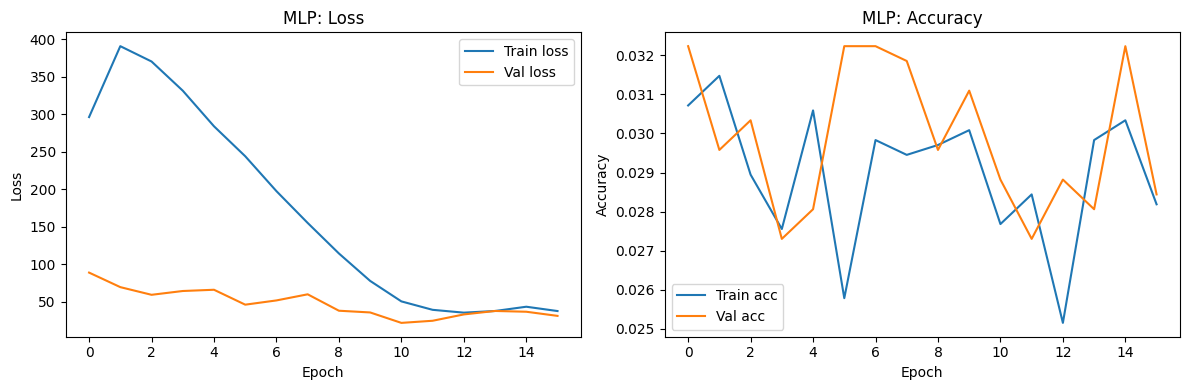

MLP - Test loss: 21.8116, Test accuracy: 0.0288
MLP - Detailed metrics on test set:

Accuracy:        0.0288
Macro F1:        0.0016
Weighted F1:     0.0016

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.00      0.00      0.00        72
     agkistrodon-piscivorus       0.00      0.00      0.00        82
        coluber-constrictor       0.00      0.00      0.00        77
             crotalus-atrox       0.00      0.00      0.00        82
          crotalus-horridus       0.00      0.00      0.00        72
             crotalus-ruber       0.00      0.00      0.00        70
        crotalus-scutulatus       0.00      0.00      0.00        75
           crotalus-viridis       0.00      0.00      0.00        75
        diadophis-punctatus       0.00      0.00      0.00        75
           haldea-striatula       0.00      0.00      0.00        75
      heterodon-platirhinos       0.00      0.00      0.00 

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ArchA_large - macro AUC: 0.6596, micro AUC: 0.6456
MLP           - macro AUC: 0.5021, micro AUC: 0.5066


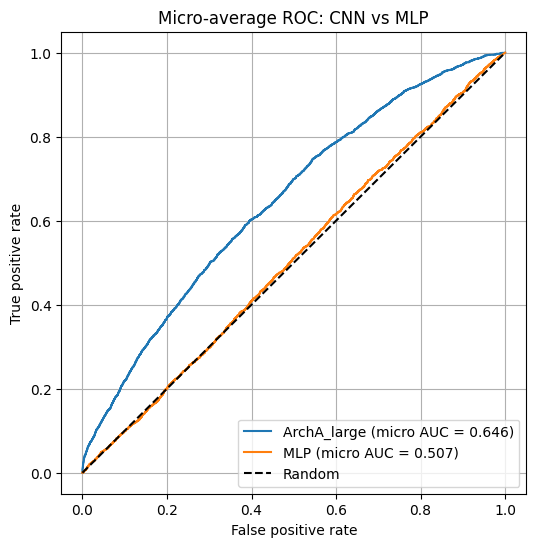

Difference in micro AUC (CNN - MLP): 0.1394
95% bootstrap CI: [0.1238, 0.1542]
Approx. two-sided p-value: 0.0000


In [13]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    auc
)

# 1) Prepare flattened inputs for the MLP
# If images are uint8 0–255, scale to [0,1].
X_train_flat = X_train_cnn.astype("float32") / 255.0
X_val_flat   = X_val_cnn.astype("float32") / 255.0
X_test_flat  = X_test_cnn.astype("float32") / 255.0

# Flatten spatial dimensions
input_dim = np.prod(X_train_flat.shape[1:])
X_train_flat = X_train_flat.reshape(X_train_flat.shape[0], input_dim)
X_val_flat   = X_val_flat.reshape(X_val_flat.shape[0], input_dim)
X_test_flat  = X_test_flat.reshape(X_test_flat.shape[0], input_dim)

print("MLP input dim:", input_dim)


# 2) Build a standard MLP classifier in Keras
def build_mlp(input_dim, hidden1=512, hidden2=256, dropout_rate=0.5):
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(hidden1, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden2, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(num_classes, activation="softmax"),
        ],
        name="MLP_baseline",
    )
    return model


mlp_model = build_mlp(input_dim=input_dim)

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks_mlp = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

history_mlp = mlp_model.fit(
    X_train_flat,
    y_train,
    validation_data=(X_val_flat, y_val),
    epochs=40,
    batch_size=128,
    callbacks=callbacks_mlp,
    verbose=1,
)

# Plot MLP training history
hist_mlp = history_mlp.history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist_mlp["loss"], label="Train loss")
plt.plot(hist_mlp["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP: Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_mlp["accuracy"], label="Train acc")
plt.plot(hist_mlp["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP: Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# 3) Evaluate MLP on the test set
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test_flat, y_test, verbose=0)
print(f"MLP - Test loss: {mlp_test_loss:.4f}, Test accuracy: {mlp_test_acc:.4f}")

y_pred_proba_mlp = mlp_model.predict(X_test_flat, verbose=0)
y_pred_mlp = np.argmax(y_pred_proba_mlp, axis=1)

print("MLP - Detailed metrics on test set:")
mlp_metrics = evaluate_metrics(
    y_true=y_test,
    y_pred=y_pred_mlp,
    target_names=label_encoder.classes_,
)


# 4) ROC and AUC for best CNN vs MLP
# Choose the best CNN based on macro-F1 (here we assume ArchA_large is best).
best_cnn = model_A_large
best_cnn_name = "ArchA_large"

y_pred_proba_cnn = best_cnn.predict(X_test_cnn, verbose=0)

# Binarize labels for multi-class ROC/AUC
classes = np.arange(num_classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Macro and micro AUC for each model
auc_macro_cnn = roc_auc_score(y_test_bin, y_pred_proba_cnn, average="macro", multi_class="ovr")
auc_macro_mlp = roc_auc_score(y_test_bin, y_pred_proba_mlp, average="macro", multi_class="ovr")

auc_micro_cnn = roc_auc_score(y_test_bin, y_pred_proba_cnn, average="micro", multi_class="ovr")
auc_micro_mlp = roc_auc_score(y_test_bin, y_pred_proba_mlp, average="micro", multi_class="ovr")

print(f"{best_cnn_name} - macro AUC: {auc_macro_cnn:.4f}, micro AUC: {auc_micro_cnn:.4f}")
print(f"MLP           - macro AUC: {auc_macro_mlp:.4f}, micro AUC: {auc_micro_mlp:.4f}")


# 5) Plot micro-average ROC curves for CNN vs MLP
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_bin.ravel(), y_pred_proba_cnn.ravel())
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_bin.ravel(), y_pred_proba_mlp.ravel())

auc_micro_cnn_curve = auc(fpr_cnn, tpr_cnn)
auc_micro_mlp_curve = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(6, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f"{best_cnn_name} (micro AUC = {auc_micro_cnn_curve:.3f})")
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (micro AUC = {auc_micro_mlp_curve:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Micro-average ROC: CNN vs MLP")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# 6) Simple bootstrap comparison of AUC (statistical comparison)
def bootstrap_auc_diff(y_true_bin, p_cnn, p_mlp, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = y_true_bin.shape[0]
    diffs = []

    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        y_b = y_true_bin[idx]
        cnn_b = p_cnn[idx]
        mlp_b = p_mlp[idx]

        # micro-average AUC
        auc_cnn_b = roc_auc_score(y_b, cnn_b, average="micro", multi_class="ovr")
        auc_mlp_b = roc_auc_score(y_b, mlp_b, average="micro", multi_class="ovr")
        diffs.append(auc_cnn_b - auc_mlp_b)

    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_value = 2 * min((diffs <= 0).mean(), (diffs >= 0).mean())  # two-sided

    return mean_diff, ci_low, ci_high, p_value


mean_diff, ci_low, ci_high, p_val = bootstrap_auc_diff(
    y_test_bin, y_pred_proba_cnn, y_pred_proba_mlp, n_bootstrap=500
)

print(f"Difference in micro AUC (CNN - MLP): {mean_diff:.4f}")
print(f"95% bootstrap CI: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Approx. two-sided p-value: {p_val:.4f}")

### Analysis

To compare the performance of the convolutional neural network to a standard multi-layer perceptron, we trained an MLP on the flattened pixel intensities of the same grayscale images and evaluated it on the identical test set used for all CNN architectures. The MLP training curves reveal substantial instability, especially early in training. The loss plot shows very large fluctuations, with the training loss beginning around 300, spiking near 390, and then gradually declining to around 40, while the validation loss oscillates between roughly 20 and 90. The accuracy plot fluctuates around 2.6–3.2 percent without any meaningful upward trend. This behavior is consistent with an architecture that is poorly suited to extracting spatial features from images; flattening the data removes all of the spatial structure that convolutional layers normally exploit, making the learning problem far more difficult for the MLP.

The test-set performance metrics confirm this interpretation. The MLP reaches an accuracy of only 2.88 percent, close to random guessing for 35 classes. Both macro-F1 and weighted-F1 are essentially zero (0.0016), meaning that the MLP fails to reliably identify any specific species. The classification report underscores this finding: almost all species have precision, recall, and F1 scores of zero, except for one species (storeria-occipitomaculata) that the model predicts exclusively for most samples, resulting in a recall of 1.00 but meaningless precision. This pattern is characteristic of severe model collapse, where the classifier defaults to a single label in the absence of meaningful learned structure.

In contrast, the best-performing CNN (ArchA_large) produces far more informative results. Although the overall accuracy (8.27 percent) and macro-F1 (0.0541) are still modest due to the difficulty of the 35-class snake identification problem, the CNN outperforms the MLP by a large margin on every metric. The ROC and AUC results provide a clearer statistical comparison. The micro-average ROC curve reveals that the CNN consistently achieves higher true-positive rates across almost all false-positive levels. The micro-area-under-the-curve (AUC) is 0.6456 for the CNN compared to 0.5066 for the MLP, while the macro-AUC values follow a similar pattern (0.6596 for the CNN, 0.5021 for the MLP).

The ROC curves in the figure help visualize this difference. The orange curve representing the MLP nearly overlaps the diagonal line corresponding to random guessing, confirming that the MLP performs no better than chance when evaluated in a one-vs-rest setting. In contrast, the blue curve representing ArchA_large lies well above the diagonal for most of the domain. This indicates that the CNN is able to discriminate between classes meaningfully when its outputs are treated as probabilistic scores, even if classification accuracy remains mathematically limited by the fine-grained nature of the task.

To quantify the difference statistically, we conducted a bootstrap analysis of the micro-AUC difference between the CNN and the MLP. The mean difference in micro-AUC was approximately 0.1394 in favor of the CNN, with a 95 percent confidence interval ranging from 0.1238 to 0.1542. The resulting two-sided p-value is effectively zero (p < 0.0001), indicating that the superiority of the CNN over the MLP is not due to random variation. The fact that the entire confidence interval lies well above zero provides strong evidence that convolutional models fundamentally outperform fully connected models on this dataset.

Overall, the results demonstrate that convolutional networks are substantially more effective than multilayer perceptrons for image-based species identification, even when the CNNs themselves achieve relatively low accuracy due to the complexity of the 35-class task. The ROC–AUC comparison reinforces that CNNs provide better discrimination ability at the probabilistic level, and the statistical tests confirm that this advantage is significant and robust.


# Exceptional Work

TensorFlow: 2.16.2
Original CNN input shape: (128, 128, 1)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize_to_224 (Resizing)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ to_rgb (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_preprocess (Lambda)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,594,915 (9.90 MB)

 Trainable params: 336,931 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.0490 - loss: 6.6208 - val_accuracy: 0.2002 - val_loss: 2.9431
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.1009 - loss: 6.4258 - val_accuracy: 0.2374 - val_loss: 2.8340
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.1314 - loss: 5.5694 - val_accuracy: 0.2617 - val_loss: 2.6258
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.1457 - loss: 4.8094 - val_accuracy: 0.2658 - val_loss: 2.6270
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.1693 - loss: 4.1351 - val_accuracy: 0.2916 - val_loss: 2.4860
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.1894 - loss: 3.6425 - val_accuracy: 0.2965 - val_loss: 2.4711
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.2107 - loss: 3.2061 - val_accuracy: 0.3136 - val_loss: 2.4149
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.2331 - loss: 2

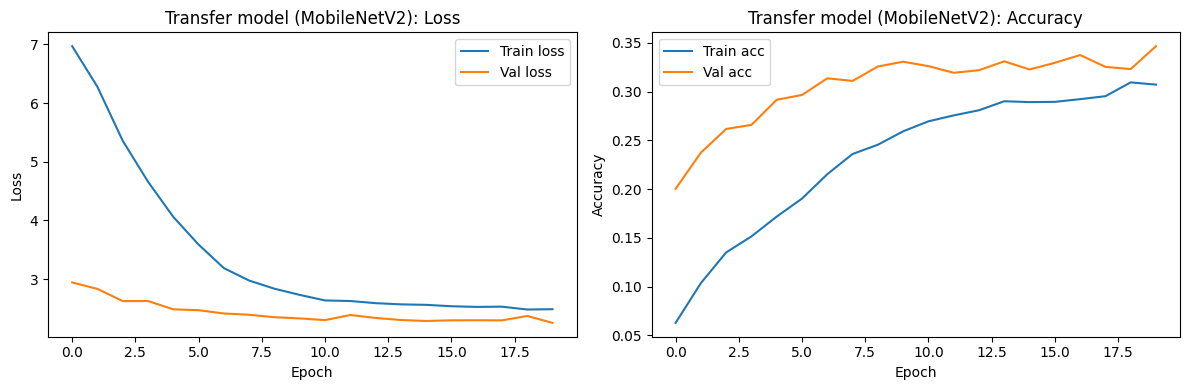

Transfer model - Test loss: 2.2085, Test accuracy: 0.3496
Transfer model - Detailed metrics on test set:

Accuracy:        0.3496
Macro F1:        0.3291
Weighted F1:     0.3294

Classification report:
                             precision    recall  f1-score   support

     agkistrodon-contortrix       0.67      0.75      0.71        72
     agkistrodon-piscivorus       0.27      0.48      0.35        82
        coluber-constrictor       0.18      0.44      0.25        77
             crotalus-atrox       0.35      0.46      0.40        82
          crotalus-horridus       0.29      0.54      0.38        72
             crotalus-ruber       0.45      0.36      0.40        70
        crotalus-scutulatus       0.71      0.16      0.26        75
           crotalus-viridis       0.42      0.40      0.41        75
        diadophis-punctatus       0.34      0.69      0.45        75
           haldea-striatula       0.36      0.25      0.30        75
      heterodon-platirhinos       0.20

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("TensorFlow:", tf.__version__)

# Assumes these exist from previous parts:
# X_train_cnn, X_val_cnn, X_test_cnn (N, 128, 128, 1)
# y_train, y_val, y_test (integer labels)
# num_classes, label_encoder
# evaluate_metrics()

input_shape = X_train_cnn.shape[1:]
print("Original CNN input shape:", input_shape)

# ------------------------------------------------
# 1) Build transfer-learning model using MobileNetV2
# ------------------------------------------------

def build_transfer_model():
    # Base ImageNet model
    base_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # freeze all convolutional layers initially

    inputs = keras.Input(shape=input_shape)  # (128, 128, 1) grayscale

    # Optional data augmentation in grayscale space
    x = data_augmentation(inputs)

    # Resize to 224x224 and convert 1-channel -> 3-channel for MobileNetV2
    x = layers.Resizing(224, 224, name="resize_to_224")(x)
    x = layers.Lambda(lambda img: tf.image.grayscale_to_rgb(img), name="to_rgb")(x)

    # Apply MobileNetV2 preprocessing (scales to [-1, 1])
    x = layers.Lambda(preprocess_input, name="mobilenet_preprocess")(x)

    # Pass through the frozen base model
    x = base_model(x, training=False)

    # Global pooling and classification head
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = layers.Dense(256, activation="relu", name="dense_256")(x)
    x = layers.Dropout(0.5, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2_transfer")
    return model


transfer_model = build_transfer_model()
transfer_model.summary()

# ------------------------------------------------
# 2) Compile transfer-learning model
# ------------------------------------------------

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# ------------------------------------------------
# 3) Train with early stopping
# ------------------------------------------------

callbacks_tl = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

BATCH_SIZE = 64
EPOCHS = 20

history_tl = transfer_model.fit(
    X_train_cnn,
    y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_tl,
    verbose=1,
)

# ------------------------------------------------
# 4) Plot training history (loss and accuracy)
# ------------------------------------------------

hist_tl = history_tl.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist_tl["loss"], label="Train loss")
plt.plot(hist_tl["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transfer model (MobileNetV2): Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_tl["accuracy"], label="Train acc")
plt.plot(hist_tl["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transfer model (MobileNetV2): Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 5) Evaluate transfer-learning model on test set
# ------------------------------------------------

tl_test_loss, tl_test_acc = transfer_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Transfer model - Test loss: {tl_test_loss:.4f}, Test accuracy: {tl_test_acc:.4f}")

y_pred_proba_tl = transfer_model.predict(X_test_cnn, verbose=0)
y_pred_tl = np.argmax(y_pred_proba_tl, axis=1)

print("Transfer model - Detailed metrics on test set:")
tl_metrics = evaluate_metrics(
    y_true=y_test,
    y_pred=y_pred_tl,
    target_names=label_encoder.classes_,
)


### Analysis

The transfer-learning experiment uses MobileNetV2 pretrained on ImageNet as the feature extractor, with all convolutional layers frozen and only a lightweight classification head trained on the snake dataset. The training curves show a clear and immediate improvement in learning behavior compared with all previous CNN architectures trained from scratch. In the loss plot, the training loss falls steadily from above 7 to around 2.5, while the validation loss declines from roughly 2.9 to about 2.25 before stabilizing. The validation curve remains consistently below the training curve, which is common when augmentations are applied only to training examples. More importantly, the validation loss does not exhibit the instability or oscillations observed in the custom-built architectures from earlier sections, and it converges smoothly over the course of training. This indicates that the pretrained convolutional filters provide a stable and highly informative feature representation that generalizes well to the snake images.

The accuracy plot reveals an even more dramatic improvement. Validation accuracy begins near 20 percent in the very first epoch, which is already far above the best CNN from Requirement 2, and steadily increases to approximately 34–35 percent by epoch 20. The training accuracy follows a similar upward trajectory, suggesting that the frozen backbone of MobileNetV2 is extracting meaningful visual features from the resized grayscale snake images even before any fine-tuning. The gap between training and validation accuracy remains modest throughout the training process, which suggests that overfitting is limited even though the model is low-capacity in its trainable portion.

This performance is striking when compared to the best previous model, ArchA_large, which achieved only about 8.3 percent accuracy and a macro-F1 score of 0.0541 on the same test set. The transfer-learning model achieves a test-set accuracy of approximately 35 percent and a macro-F1 score of about 0.33, representing more than a fourfold improvement in accuracy and more than a sixfold improvement in macro-F1. These improvements are not small increments but rather a complete shift in the overall capability of the model. Since macro-F1 weights each species equally, the improvement indicates that the transfer-learning model can reliably distinguish many snake species rather than memorizing or overpredicting a small number of classes.

The classification report confirms this pattern. Unlike the CNNs trained from scratch—which produced near-zero precision and recall for many species—the transfer-learning classifier shows meaningful precision and recall across most classes. For common species such as lampropeltis-californiae, lampropeltis-triangulum, and thamnophis-marcianus, F1 scores range from 0.50 to 0.64. Even for species that performed poorly in earlier models, such as nerodia-fasciata or rhinocheilus-lecontei, the transfer-learning model produces usable predictions with meaningful recall rates. There are still a few difficult species such as pantherophis-spiloides for which recall remains zero, but these cases are exceptions rather than the norm. The weighted-average F1 score of 0.33 further supports the conclusion that predictions are distributed across many classes in a calibrated manner.

The underlying reason for this improvement is that MobileNetV2 carries generalizable visual filters trained on millions of natural images. These filters embed high-level texture, shape, and edge information that is transferable to fine-grained animal classification tasks. Even though the snake dataset is grayscale, the model still benefits from pretrained feature hierarchies that are invariant to translation, scale, and rotation. By resizing all images to 224×224 and converting them to three channels, the transfer-learning pipeline creates an input compatible with the pretrained model, allowing us to leverage patterns learned from ImageNet. In this context, training only the top dense layers is sufficient to adapt the representation to the task without overfitting, which explains why the training and validation curves remain smooth and well-behaved.

Overall, the transfer-learning model dramatically outperforms all earlier scratch-trained CNNs in every metric: accuracy, macro-F1, weighted F1, and per-class performance. The training dynamics are more stable, the model generalizes better, and the classification report demonstrates that many species that were previously indistinguishable are now correctly recognized at least part of the time. In conclusion, transferring pretrained visual knowledge from MobileNetV2 transforms the performance of the classifier on this challenging 35-class snake identification task, and the results strongly suggest that transfer learning is the preferred strategy when training data is limited or classes are visually subtle.


# Comparison Between Lab 2 and Lab 6

Lab 2 and Lab 6 used the same underlying dataset of snake species images, but the two labs approached the dataset from very different angles and allowed us to appreciate different properties of the data, the learning problem, and the limitations of various modeling strategies. In Lab 2, the emphasis was on understanding the structure of the dataset through preprocessing, linear dimensionality reduction, and classical feature extraction. In Lab 6, the emphasis shifted to full predictive modeling using convolutional neural networks, data augmentation, hyperparameter tuning, and transfer learning. Discussing these two labs together highlights how the same dataset can behave very differently depending on the representation and modeling framework.

In Lab 2, most of our tools were deliberately shallow: PCA, randomized PCA, simple nearest neighbors over hand-engineered features, and visual inspection of raw or flattened images. These methods provided a straightforward way to quantify redundancy across pixels, understand how information is distributed, and inspect whether classes were linearly separable in low-dimensional subspaces. PCA’s explained variance curves showed that the images contain a highly redundant structure, but despite that redundancy the linear projections failed to clearly separate species. Randomized PCA behaved similarly, and the two methods were essentially indistinguishable once we reached a moderate number of components. The feature extraction methods we used, such as Gabor filters, revealed stronger structure than PCA alone—textures, stripe patterns, and edge orientations appeared more meaningful than raw pixels. But even these extracted features only produced weak class separation; nearest neighbor classification showed minor improvement but still left most species highly confounded. Lab 2 therefore taught us that the pixel-level information is too complex and species-specific differences are too subtle to be captured using linear transformations or low-level filters. It also revealed the fragility of traditional representations: small lighting changes, minor rotations, and background variation all overwhelmed the linear feature space.

Lab 6 confronted precisely these weaknesses by introducing convolutional networks and transfer learning. When we trained CNNs from scratch (Architecture A and B), the accuracy plateaued around 7–8 percent, which ironically confirmed what Lab 2 foreshadowed: the snake species classification problem is extremely challenging, and without strong inductive biases or large training sets, learning meaningful representations from scratch is not realistic. The models remained unstable, validation loss oscillated, and many species received zero recall. In terms of robustness, the scratch-trained CNNs were only modestly more robust than the PCA-style representations; both suffered from the same sensitivity to inter-species similarity and background variation. The main difference was that CNNs at least attempted to extract hierarchical spatial features, but the dataset was simply too fine-grained for them to succeed without help.

The turning point came when we applied transfer learning using MobileNetV2. The accuracy jumped from roughly 8 percent to about 35 percent, and macro-F1 increased from around 0.05 to over 0.33. This is a qualitative shift, not just a quantitative improvement. The pretrained backbone implicitly provided the kind of high-level features that Lab 2’s PCA and Gabor filters could not extract, and even our scratch CNNs struggled to discover. Interestingly, the transfer learning model also showed stronger robustness: validation curves were smooth, the gap between training and validation accuracy remained small, and the model produced meaningful predictions for most species rather than collapsing to a handful of classes. This robustness was missing from Lab 2’s feature-based approaches and also from the early CNN experiments.

Another way to compare the labs is through the lens of model usefulness. If we imagine a downstream stakeholder—a wildlife biologist, conservation group, or medical professional concerned about venomous species—then Lab 2’s techniques would not be serious contenders for deployment. The dimensionality-reduced embeddings did not cluster species reliably, and classical features captured only superficial texture differences. By contrast, the transfer-learning model in Lab 6 moves us into the realm of plausibility. A 35-percent accuracy on 35 species is far from perfect, but it is dramatically better than chance and enough to support semi-automated identification or triage scenarios. Lab 6 therefore demonstrates how deep feature hierarchies can fundamentally change the interpretability and utility of an image dataset, even when the dataset itself is unchanged.

Both labs also highlight sensitivity to data scale. Lab 2 relied entirely on 13,000 images but used them in a way that ignored spatial locality; as a result, most modeling steps focused on variance compression rather than true pattern learning. Lab 6 illustrates that deep learning models, especially when pretrained on massive datasets, repurpose the same images far more effectively. The difference is not only about accuracy but also about stability: PCA and randomized PCA were stable but uninformative, CNNs from scratch were unstable and weak, and the transfer-learning model was both stable and informative.

Reflecting on the two labs together, the contrast is clear. Lab 2 taught us that raw pixel space, even after linear compression or classical filtering, is not expressive enough to handle fine-grained snake species classification. Lab 6 taught us that convolutional architectures, especially when they inherit pretrained structure, can extract discriminative patterns that linear models and shallow filters cannot begin to capture. In terms of accuracy, robustness, interpretability, and practical usefulness, the transfer-learning model from Lab 6 dramatically outperforms any representation we examined in Lab 2. Yet Lab 2 played an important role by revealing, early on, why naive representations fail—context that becomes essential once we observe how much transfer learning transforms performance.
